2018 Oct 9<br>
Since I'm getting a little short on time for DPS, I'm going to do a quick once-through of the planned full analysis using the Levenberg-Marquardt approach, with simplified error estimates. Later, I'll go back through with the MCMC analysis to clean up uncertainty estimates.

In [28]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from lightkurve import KeplerLightCurveFile

from evilmc import evparams, evmodel, convert_Kz
from transit_utils import bindata, transit_duration
from variable_eclipses_utils import *

from BEER_curve import BEER_curve

import emcee
from emcee.autocorr import integrated_time

import dill

K76 = Kepler76_params()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
num_period = 1
binsize = 30./60./24.
    
# Retrieve while masking out transit
time, flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, num_periods=num_period, 
                                                         KIC=K76.KIC, fit_bottom=True, params=K76.saved_ep, 
                                                         drop_outliers=True)
folded_time = filtered_time % K76.saved_ep.per

# Estimate scatter
ind = ~transit_indices(folded_time, 2.*K76.dur, K76.T0)
unbinned_noise = mad(filtered_flux[ind])
print(unbinned_noise*1e6)

141.83679022846897


In [29]:
def fit_all_signals(cur_time, cur_baseline, cur_p, cur_b, cur_T0, cur_Aellip, cur_Abeam,
        cur_F0, cur_Aplanet, cur_phase_shift):
    params = K76.saved_params.copy()

    params['baseline'] = cur_baseline
    params['p'] = cur_p
    params['b'] = cur_b
    params['T0'] = cur_T0
    params['Aellip'] = cur_Aellip
    params['Abeam'] = cur_Abeam
    params['F0'] = cur_F0
    params['Aplanet'] = cur_Aplanet
    params['phase_shift'] = cur_phase_shift

    cur_BC = BEER_curve(cur_time, params,
            supersample_factor=10, exp_time=30./60./24.)

    return cur_BC.all_signals()

In [30]:
bounds = ([-1000e-6, 0., -1, K76.T0*0.95, -500e-6, -500e-6, -500e-6, 0., -1],
          [1000e-6, 0.2, 1., K76.T0*1.05, 500e-6, 500e-6, 500e-6, 500e-6, 1])

# Estimate scatter
ind = ~transit_indices(folded_time, K76.dur, K76.T0)
unbinned_noise = mad(filtered_flux[ind])

time = folded_time
data = filtered_flux
err = unbinned_noise*np.ones_like(folded_time)

initial_guess = [0., K76.saved_params['p'], K76.saved_params['b'], 
                 K76.saved_params['T0'], K76.saved_params['Aellip'], K76.saved_params['Abeam'], K76.saved_params['F0'], 
                 K76.saved_params['Aplanet'], K76.saved_params['phase_shift']]
popt, pcov = curve_fit(fit_all_signals, time, data, sigma=unbinned_noise*np.ones_like(time), p0=initial_guess, bounds=bounds)
uncertainties = np.sqrt(pcov.diagonal())

print(popt)
print(uncertainties)

[-2.50231601e-05  1.05220778e-01  9.59199057e-01  6.84991475e-01
  1.24302356e-05 -1.05941984e-04  5.34654604e-05  1.25042416e-04
 -1.89212339e-01]
[5.56009160e-06 6.37770606e-04 1.04122202e-03 1.94798772e-05
 1.00793870e-06 2.06183162e-04 5.63663040e-06 1.91339964e-04
 9.78131921e-02]


(-0.0001, 0.0001)

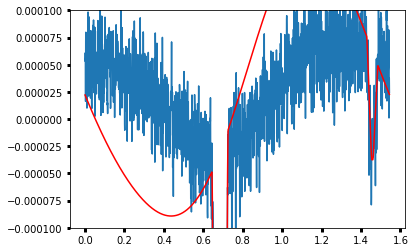

In [32]:
binned_time, binned_flux, binned_err = bindata(folded_time, filtered_flux, 1./60./24.)

test_popt = popt.copy()
test_popt[5] = 0.

plt.plot(binned_time, binned_flux)
plt.plot(binned_time, fit_all_signals(binned_time, *test_popt), color='red')

plt.ylim([-100e-6, 100e-6])